In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import binned_statistic
from rfpimp import plot_corr_heatmap
from sklearn.metrics import confusion_matrix

In [2]:
features_df = pd.read_hdf('/cosma6/data/dp004/dc-cues1/tng_dataframes/merged_dataframe.h5')

In [3]:
features_df = features_df.fillna(-9999)

In [4]:
features_df = features_df.replace([-np.inf, np.inf], 0.)

Text(0,0.5,'$\\beta$')

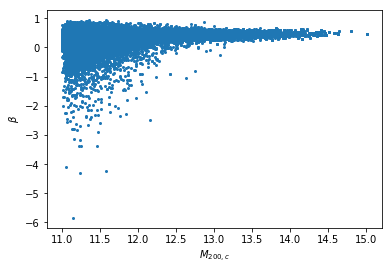

In [5]:
plt.plot(features_df.M200c[features_df.vel_ani_param > -900], 
         features_df.vel_ani_param[features_df.vel_ani_param > -900],
         linestyle='', marker='o', markersize=2)
plt.xlabel('$M_{200,c}$')
plt.ylabel(r'$\beta$')

## Compare stellar mass cut on the central galaxy with dark/luminous
 Could one of the non-central subhalos be the luminous one?


In [6]:
log_m_stars = np.log10(features_df.M_stars)
log_m_stars = log_m_stars.replace([-np.inf, np.inf], 0.)

/cosma/home/dp004/dc-cues1/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
cm = confusion_matrix(features_df.N_gals > 0,
                    log_m_stars > 9,
                     )

In [8]:
cm

array([[ 52237,      0],
       [   213, 158674]])

In [9]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


In [10]:
cm

array([[1.        , 0.        ],
       [0.00134058, 0.99865942]])

It seems to be the case, there are 213 cases in which the luminous subhalo is not the central one

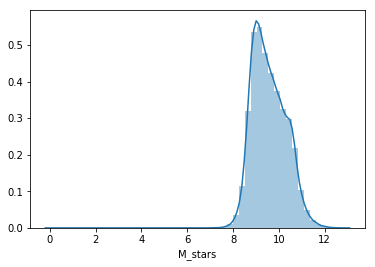

In [11]:
sns.distplot(log_m_stars)

# Check features and their correlations

In [12]:
reduced_df = features_df.drop(columns=['x_hydro', 'y_hydro', 'z_hydro',
                                      'x_dmo', 'y_dmo', 'z_dmo', 'ID_HYDRO', 'ID_DMO',
                                      'ID_HYDRO', 'M200_HYDRO', 'Rmax',
                                      'M_stars',
                                      ])

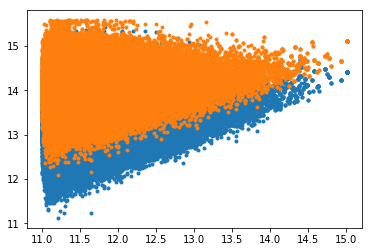

In [13]:
plt.plot(features_df.M200c, features_df.env_5, linestyle='',
          marker='o', markersize=3)
plt.plot(features_df.M200c, features_df.env_10, linestyle='',
          marker='o', markersize=3)

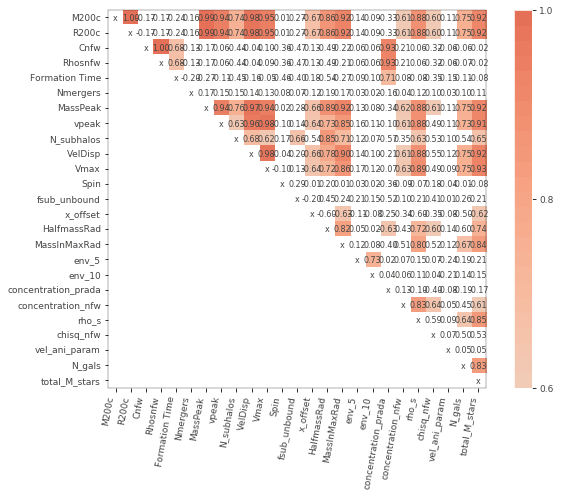

In [14]:
viz = plot_corr_heatmap(reduced_df, figsize=(10,7))


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


ValueError: num must be 1 <= num <= 24, not 25

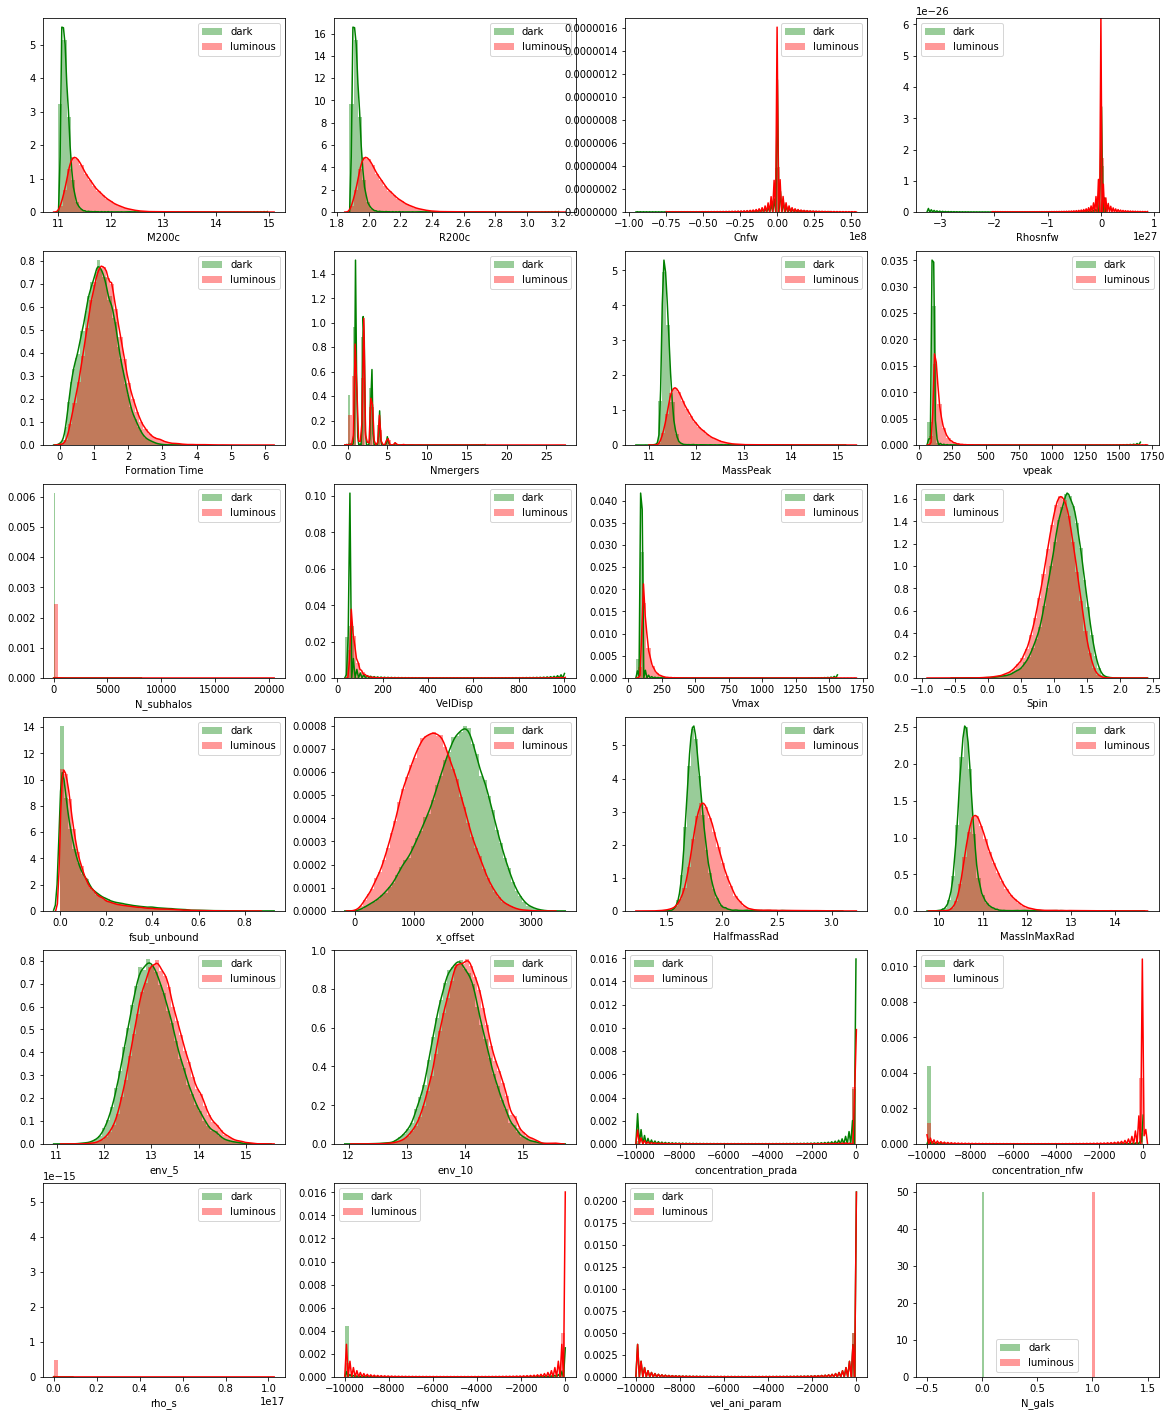

In [15]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in reduced_df.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(reduced_df[i][reduced_df['N_gals']==0],
                 color='g', label = 'dark')
    sns.distplot(reduced_df[i][reduced_df['N_gals']==1],
                 color='r', label = 'luminous')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [17]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict


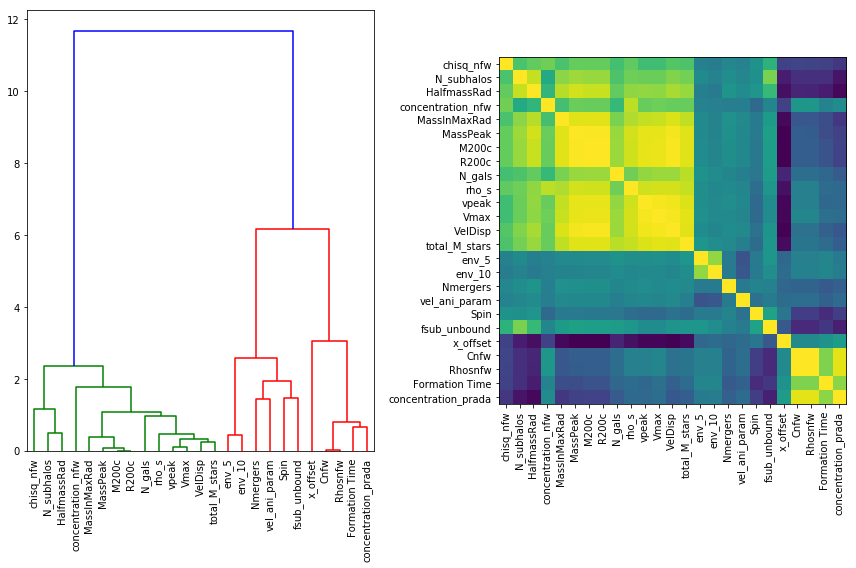

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))


corr = spearmanr(reduced_df).correlation
corr_linkage = hierarchy.ward(corr)

dendro = hierarchy.dendrogram(corr_linkage, labels=reduced_df.columns, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))


ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [19]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]



In [20]:
corr = spearmanr(reduced_df[reduced_df.columns[selected_features]]).correlation


In [21]:
reduced_df.columns[selected_features].values

array(['M200c', 'Cnfw', 'Nmergers', 'vpeak', 'N_subhalos', 'Spin',
       'fsub_unbound', 'x_offset', 'env_5', 'concentration_nfw',
       'chisq_nfw', 'vel_ani_param'], dtype=object)

In [22]:
from gahaco.features.correlation import select_uncorrelated_features

In [23]:
uncorrelated_df = select_uncorrelated_features(reduced_df)

In [24]:
uncorrelated_df.columns

Index(['M200c', 'Cnfw', 'Nmergers', 'vpeak', 'N_subhalos', 'Spin',
       'fsub_unbound', 'x_offset', 'env_5', 'concentration_nfw', 'chisq_nfw',
       'vel_ani_param'],
      dtype='object')

In [140]:
uncorrelated_df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            211114, 211115, 211116, 211117, 211118, 211119, 211120, 211121,
            211122, 211123],
           dtype='int64', length=211124)

In [139]:
reduced_df.Nmergers

0         3.0
1         3.0
2         3.0
3         3.0
4         3.0
         ... 
211119    0.0
211120    1.0
211121    4.0
211122    4.0
211123    2.0
Name: Nmergers, Length: 211124, dtype: float64

In [ ]:
plt.plot(uncorrelated_df.M200c, reduced_df.M200c, linestyle='', marker='o')

In [ ]:
reduced_df[reduced_df.columns[selected_features].values]

In [ ]:
plt.imshow(corr)
plt.xticks(range(len(reduced_df.columns[selected_features].values)),
                 reduced_df.columns[selected_features].values,
           rotation='vertical')

plt.yticks(range(len(reduced_df.columns[selected_features].values)),
                 reduced_df.columns[selected_features].values)

In [49]:
nbins = 30
halo_mass = 10**reduced_df['M200c']
mass_bins = np.logspace(np.log10(np.min(halo_mass)), np.log10(np.max(halo_mass)), nbins + 1)
mass_c = 0.5 * (mass_bins[1:] + mass_bins[:-1])

mean_gals_per_mass, _, _ = binned_statistic(halo_mass, reduced_df['N_gals']>0,
                                            statistic = 'mean',
                                            bins=mass_bins)


std_gals_per_mass, _, _ = binned_statistic(halo_mass, reduced_df['N_gals']>0,
                                            statistic = 'std',
                                            bins=mass_bins)



In [50]:
luminous_temporal_order = reduced_df.sort_values('Formation Time')


In [51]:
luminous_youngest = luminous_temporal_order[:int(0.25*len(luminous_temporal_order))]

youngest_mean_gals_per_mass, _, _ = binned_statistic(10**luminous_youngest.M200c,
                                            luminous_youngest['N_gals']>0,
                                            statistic = 'mean',
                                            bins=mass_bins)


youngest_std_gals_per_mass, _, _ = binned_statistic(10**luminous_youngest.M200c,
                                            luminous_youngest['N_gals']>0,
                                            statistic = 'std',
                                            bins=mass_bins)

In [52]:
luminous_oldest = luminous_temporal_order[-int(0.25*len(luminous_temporal_order)):]

oldest_mean_gals_per_mass, _, _ = binned_statistic(10**luminous_oldest.M200c,
                                            luminous_oldest['N_gals']>0,
                                            statistic = 'mean',
                                            bins=mass_bins)

oldest_std_gals_per_mass, _, _ = binned_statistic(10**luminous_oldest.M200c,
                                            luminous_oldest['N_gals']>0,
                                            statistic = 'std',
                                            bins=mass_bins)

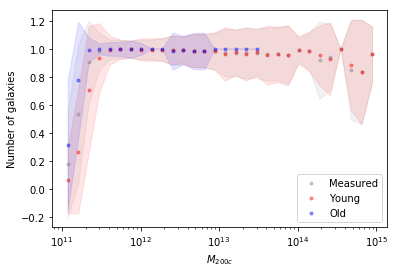

In [54]:
fig = plt.figure()
ax = plt.axes()
ax.plot(mass_c, mean_gals_per_mass,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'gray', alpha = 0.4, label = 'Measured')

ax.fill_between(mass_c, mean_gals_per_mass-std_gals_per_mass,
              mean_gals_per_mass+std_gals_per_mass, alpha = 0.1,
                color='gray')

ax.plot(mass_c, youngest_mean_gals_per_mass,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'red', alpha = 0.4, label = 'Young')

ax.fill_between(mass_c, youngest_mean_gals_per_mass-youngest_std_gals_per_mass,
              youngest_mean_gals_per_mass+youngest_std_gals_per_mass, alpha = 0.1,
               color = 'red')

ax.plot(mass_c, oldest_mean_gals_per_mass,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'blue', alpha = 0.4, label = 'Old')

ax.fill_between(mass_c, oldest_mean_gals_per_mass-oldest_std_gals_per_mass,
              oldest_mean_gals_per_mass+oldest_std_gals_per_mass, alpha = 0.1,
               color = 'blue')

ax.set_xscale("log")
#ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()